In [ ]:
import cv2 
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import joblib
import heapq
from collections import defaultdict


### Feature Extraction
Extraer los features de las imagenes de la carpeta utilizando opencv con SIFT.

```keypoints, descriptors = sift.detectAndCompute(gray, None)```
- keypoints almacena las coordenadas (x,y) de cada keypoint de la imagen (esquinas, manchas, cambios bruscos de intensidad, etc).
- descriptors almacena los descriptores para cada keypoint de esa imagen (128 descriptores).

In [25]:
# Extracción/cargar descriptores y aplicar PCA (analisis del pca en la sección de Analisis)
def generate_descriptors(dataset_path, n_components_pca, 
                         pca_model_path="../Image_descriptors/pca_model.pkl", 
                         descriptors_path="../Image_descriptors/descriptors.npz"):

    if os.path.exists(pca_model_path) and os.path.exists(descriptors_path):
        # Cargar descriptores y pca desde los archivos si es que ya fueron generados
        pca = joblib.load(pca_model_path)
        data = np.load(descriptors_path, allow_pickle=True)
        reduced_descriptors = data["descriptors"] # Descriptores
        image_paths = data["filenames"] # Nombre del archivo de cada array de descriptores
        print(f"{len(reduced_descriptors)} descriptores cargados")
    
    else: 
        # Generar descriptores por primera vez
        sift = cv2.SIFT_create()
        extracted_descriptors = []
        image_paths = [] # Paths de las imagenes de las que se pudo extraer descriptores

        for filename in os.listdir(dataset_path):
            file_path = os.path.join(dataset_path, filename)
            if os.path.isfile(file_path):
                img = cv2.imread(file_path)
                if img is None:
                    continue

                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                keypoints, descriptors = sift.detectAndCompute(gray, None)

                if descriptors is not None:
                    image_paths.append(os.path.splitext(filename)[0]) #guardar el nombre del archivo sin la extensión ".jpg"
                    extracted_descriptors.append(descriptors.astype(np.float32))

        print(f"Descriptores extraidos de {len(extracted_descriptors)} imagenes")

        # Combinar descriptores para entrenar pca
        all_descriptors = np.vstack(list(extracted_descriptors))
        pca = PCA(n_components=n_components_pca)
        pca.fit(all_descriptors) #entrenar pca

        # Aplicar PCA a los descriptores
        reduced_descriptors = []
        for d in extracted_descriptors:
            reduced_descriptors.append(pca.transform(d).astype(np.float32))
        
        # Guardo en un archivo los descriptores con el nombre de la imagen y en otro archivo el objeto pca, para aplicar pca en las queries
        reduced_descriptors = np.array(reduced_descriptors, dtype=object)
        np.savez_compressed(descriptors_path, descriptors=reduced_descriptors, filenames=image_paths)
        joblib.dump(pca, "pca_model.pkl") 
        print(f"{len(reduced_descriptors)} descriptores generados")

    
    print(f"Varianza retenida: {pca.explained_variance_ratio_.sum():.2%}") # Varianza retenida por el pca
    return reduced_descriptors, image_paths, pca

def apply_kmeans(descriptors, n_clusters):
    # K-Means para construir el diccionario visual
    if os.path.exists("kmeans_model.pkl"):
        kmeans = joblib.load("kmeans_model.pkl")
    else: 
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto") #n_clusters con el que obtuvimos mejores resultados
        kmeans.fit(np.vstack(descriptors))
        joblib.dump(kmeans, "kmeans_model.pkl")

    return kmeans

def construct_bd_histograms(descriptors, kmeans):
    # Construcción de histogramas por imagen
    all_histograms = []
    for descriptor in descriptors:
        histogram = np.zeros(kmeans.n_clusters, dtype=int)

        if descriptor is not None:
            cluster_assignments = kmeans.predict(descriptor)
            for idx in cluster_assignments:
                histogram[idx] += 1

        # Normalización
        histogram = histogram.astype(float)
        histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
        all_histograms.append(histogram)
    
    return all_histograms

def create_query_histogram(query__path, kmeans, pca): 
    sift = cv2.SIFT_create()
    img = cv2.imread(query__path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:
        print(f"No keypoints found in image: {query__path}")
        return np.zeros(kmeans.n_clusters, dtype=float)

    descriptors_reduced = pca.transform(descriptors) # Aplicar pca a la query
    
    # Calcular histograma de la query
    histogram = np.zeros(kmeans.n_clusters, dtype=int)
    if descriptors_reduced is not None:
        cluster_assignments = kmeans.predict(descriptors_reduced)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    return histogram

def calcular_tf_idf(descriptors, all_histograms, kmeans):
    N = len(descriptors) #equivalente a la cantidad de imagenes 
    all_histograms = np.array(all_histograms, dtype=np.float32) 

    tf = all_histograms  # Como ya normalizamos antes, el tf es el histograma

    idf = []
    for i in range(kmeans.n_clusters): #i es el índice del visual word
        df = np.sum(all_histograms[:, i] > 0) # all_histograms > 0 me da una matriz de booleanos (si aparece el word o no en el doc)
        idf.append(np.log(N / (df + 1e-8))) # Sumo constante chiquita para evitar división por cero

    idf_np = np.array(idf, dtype=np.float32)
    tf_idf = tf * idf_np # (num_imagenes, num_clusters). tf_idf[i][j] es la importancia del visual word j en la imagen i

    return tf_idf, idf_np #retorno idf_np para poder aplicarlo a la query

def knn_secuencial(query_hist, k, idf_np, all_histograms, image_paths):
    # Aplicar TF-IDF al histograma de la query
    query = query_hist * idf_np

    heap = []
    for i, hist in enumerate(all_histograms):
        dot = np.dot(query, hist)
        norm_query = np.linalg.norm(query)
        norm_hist = np.linalg.norm(hist)

        cosine_sim = 0
        if norm_query != 0 and norm_hist != 0:
            cosine_sim = dot / (norm_query * norm_hist)


        heapq.heappush(heap, (cosine_sim, image_paths[i]))  

        if len(heap) > k:
            heapq.heappop(heap)  # eliminar el menos similar

    # Mostrar resultados en orden descendente de similitud 
    top_k = sorted(heap, reverse=True)
    return top_k

#### KNN INVERTIDO ####
def construir_indice_invertido(all_histograms):
    inverted_index = defaultdict(set)
    for img_idx, hist in enumerate(all_histograms):
        for word_id, freq in enumerate(hist):
            if freq > 0:
                inverted_index[word_id].add(img_idx)
    return inverted_index

def obtener_candidatos(query_hist, inverted_index):
    candidatos = set()
    for word_id, freq in enumerate(query_hist):
        if freq > 0:
            candidatos.update(inverted_index.get(word_id, []))
    return candidatos

def knn_con_indice(query_hist, k, idf_np, all_histograms, image_paths, inverted_index):
    query = query_hist * idf_np
    norm_query = np.linalg.norm(query)
    heap = []

    # Visual words presentes en la query
    visual_words = np.where(query_hist > 0)[0]

    # Conjunto de candidatos
    candidatos = set()
    
    for word in visual_words:
        candidatos.update(inverted_index[word])
    print(f"Candidatos a comparar: {len(candidatos)} de {len(image_paths)}")

    for idx in candidatos:
        hist = all_histograms[idx]
        norm_hist = np.linalg.norm(hist)

        cosine_sim = 0
        if norm_query != 0 and norm_hist != 0:
            cosine_sim = np.dot(query, hist) / (norm_query * norm_hist)

        heapq.heappush(heap, (cosine_sim, image_paths[idx]))
        if len(heap) > k:
            heapq.heappop(heap)

    top_k = sorted(heap, reverse=True)
    return top_k

def knn_con_indice2(query_hist, k, idf_np, all_histograms, image_paths, inverted_index):
    query = query_hist * idf_np
    norm_query = np.linalg.norm(query)

    # Obtener visual words presentes en la query
    visual_words = np.where(query_hist > 0)[0]

    # Conjunto de candidatos por índice invertido
    candidatos = set()
    for word in visual_words:
        candidatos.update(inverted_index[word])
    print(f"Candidatos a comparar: {len(candidatos)} de {len(all_histograms)}")

    if len(candidatos) == 0:
        print("❌ No se encontraron candidatos para comparar.")
        return []

    # Convertir lista de índices en array
    candidatos = np.array(list(candidatos))

    # Seleccionar solo los histogramas de candidatos
    cand_histograms = all_histograms[candidatos]

    # Normalizar los histogramas candidatos
    cand_norms = np.linalg.norm(cand_histograms, axis=1)
    sim = np.dot(cand_histograms, query) / (cand_norms * norm_query + 1e-10)

    # Obtener top-k
    top_k_indices = np.argsort(sim)[-k:][::-1]
    top_k = [(sim[i], image_paths[candidatos[i]]) for i in top_k_indices]

    return top_k

#### KNN INVERTIDO ####

def print_top_results(top_k): # Para que en los analisis de kmeans no imprima cada rato, separo los print
    print("\nTop imágenes más similares:")
    for sim, name in top_k:
        print(f"{name}: similitud = {sim:.4f}")

def show_top_similar_images(top_k, query_image_path, dataset_path):
    plt.figure(figsize=(18, 5))

    # Mostrar imagen de la query
    img_query = cv2.imread(query_image_path)
    img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(top_k) + 1, 1)
    plt.imshow(img_query)
    plt.title("Query")
    plt.axis("off")

    # Mostrar las imágenes similares
    for rank, (sim, filename) in enumerate(top_k, start=2):
        img_path = os.path.join(dataset_path, filename + ".jpg") 
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(top_k) + 1, rank)
        plt.imshow(img)
        plt.title(f"Sim: {sim:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### Teoría tf-idf

Aplicar ponderación TF-IDF

- Los documentos son las imagenes
- Los words son los clusters, cada cluster es un visual word

![Visual Histogram](../imgs/visual_hist.png)



Para la imagen de la bici tengo un histograma, cuento cuantas veces aparece cada descriptor en esa imagen de la bici.

El tf seria algo como [5/7, 1/7, 1/7, 0/7] donde 7 es el total de términos en la imagen (total de palabras en el documento)
- tf = $\frac{n_{id}}{n_d}$
- idf = $log(\frac{N}{n_i})$

El df seria el número de imagenes donde el visual word i aparece (al menos una vez). *la palabra x aparece en y documentos*

![TF-IDF](../imgs/tf_idf.png)

Calcular Document frequency, ejemplo:
```py
histograms = np.array([
  [3, 0, 1],   # Imagen 1
  [0, 2, 0],   # Imagen 2
  [1, 0, 5],   # Imagen 3
])
```
- Visual word 0 aparece en las imagenes 1 y 3. Image 1 and 3.
- Visual word 2 aparece en la imagen 2.
- Visual word 3 aparece en las imagenes 1 y 3.

```histograms > 0``` me da una matriz booleana. Si un visual word aparece en el documento (cluster) seria True:
```py
[
  [True,  False, True ],
  [False, True,  False],
  [True,  False, True ]
]
```
Luego con ```np.sum()```  sumo veo en cuantos documentos aparece cada visual word (cuenta los True).


### Pipeline

In [11]:
# CAMBIAR PATH A DONDE TIENES EL DATASET COMPLETO GUARDADO, o al path de los dataset chiquitos
#dataset_path = "C:/Users/davie/Downloads/fashion_small/images/"
#query_path = "C:/Users/davie/Downloads/fashion_small/images/5730.jpg"
dataset_path = "C:/Users/MSI/Downloads/dataset_ImagenesBD2/images/"
query_path = "C:/Users/MSI/Downloads/dataset_ImagenesBD2/images/5730.jpg"

# numero de componentes pca y clusters KMeans. En la sección "análisis" abajo hicimos un analisis para elegir esos valores
n_components = 90 
n_clusters = 250

descriptors, image_paths, pca = generate_descriptors(dataset_path, n_components)
kmeans = apply_kmeans(descriptors, n_clusters)
all_histograms = construct_bd_histograms(descriptors, kmeans)
tf_idf, idf = calcular_tf_idf(descriptors, all_histograms, kmeans)

np.savez_compressed("tfidf_data.npz", tf_idf=tf_idf, idf=idf, image_paths=image_paths)
query_histogram = create_query_histogram(query_path, kmeans, pca)



44327 descriptores cargados
Varianza retenida: 97.74%


## KNN Y KNN Invertido


⏱ Tiempo KNN Secuencial: 0.2031 segundos

Top imágenes más similares:
5730: similitud = 0.9947
45671: similitud = 0.4923
9957: similitud = 0.4661
37565: similitud = 0.4119
36698: similitud = 0.4107
31949: similitud = 0.4038
42705: similitud = 0.3834
38983: similitud = 0.3830
21297: similitud = 0.3809
34073: similitud = 0.3713


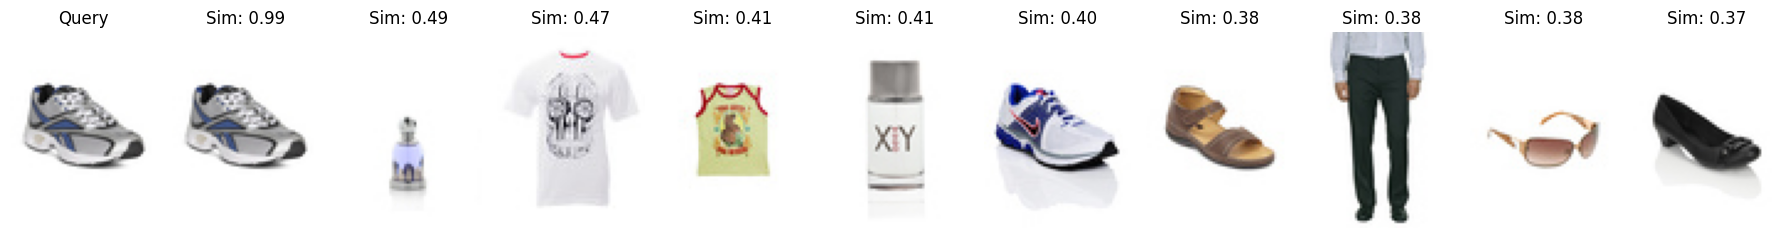

Candidatos a comparar: 31946 de 44327

⏱ Tiempo KNN con Índice Invertido: 0.8652 segundos

Top imágenes más similares:
5730: similitud = 0.9947
45671: similitud = 0.4923
9957: similitud = 0.4661
37565: similitud = 0.4119
36698: similitud = 0.4107
31949: similitud = 0.4038
42705: similitud = 0.3834
38983: similitud = 0.3830
21297: similitud = 0.3809
34073: similitud = 0.3713


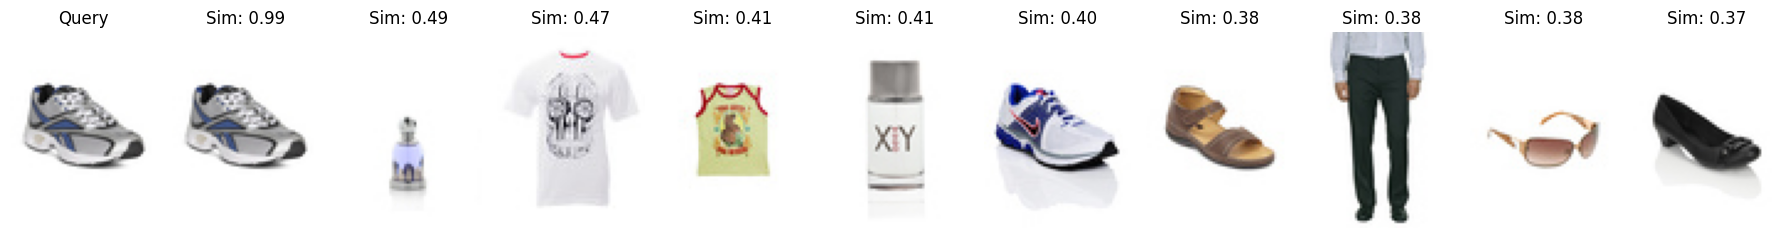

In [26]:
import time

k = 10

# === KNN Secuencial ===
start_time_seq = time.perf_counter()
top_k_results_seq = knn_secuencial(query_histogram, k, idf, all_histograms, image_paths)
end_time_seq = time.perf_counter()

print(f"\n⏱ Tiempo KNN Secuencial: {end_time_seq - start_time_seq:.4f} segundos")
print_top_results(top_k_results_seq)
show_top_similar_images(top_k_results_seq, query_path, dataset_path)


# === KNN con Índice Invertido ===
all_histograms_np = np.array(all_histograms, dtype=np.float32)

start_time_inv = time.perf_counter()
inverted_index = construir_indice_invertido(all_histograms)
#top_k_results_inv = knn_con_indice(query_histogram, k, idf, all_histograms, image_paths, inverted_index)
top_k_results_inv = knn_con_indice2(query_histogram, k, idf, all_histograms_np, image_paths, inverted_index)

end_time_inv = time.perf_counter()

print(f"\n⏱ Tiempo KNN con Índice Invertido: {end_time_inv - start_time_inv:.4f} segundos")
print_top_results(top_k_results_inv)
show_top_similar_images(top_k_results_inv, query_path, dataset_path)


### Análisis PCA y KMeans

#### PCA

Como son muchos datos y el vector de SIFT es grande podemos utilizar reducción de dimensionalidad. Hacemos un análisis para saber cuantas componentes usamos en el PCA. Utilizamos menos imagenes para ese analisis.

Total images:  1000
Componentes: 10 varianza acumulada: 0.571979.
Componentes: 20 varianza acumulada: 0.734423.
Componentes: 30 varianza acumulada: 0.818874.
Componentes: 40 varianza acumulada: 0.869553.
Componentes: 50 varianza acumulada: 0.906059.
Componentes: 60 varianza acumulada: 0.932594.
Componentes: 70 varianza acumulada: 0.951752.
Componentes: 80 varianza acumulada: 0.966586.
Componentes: 90 varianza acumulada: 0.977817.
Componentes: 100 varianza acumulada: 0.986567.
Componentes: 110 varianza acumulada: 0.993040.
Componentes: 120 varianza acumulada: 0.997689.


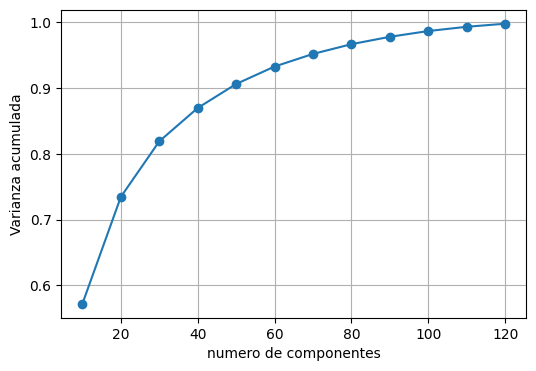

In [23]:
sift = cv2.SIFT_create()
all_descriptors = []

tiny_dataset_path = "../data/fashion_small_1000/" 
#Extraer descriptores
image_filenames = []
for filename in os.listdir(tiny_dataset_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        full_path = os.path.join(tiny_dataset_path, filename)
        image_filenames.append(full_path)

total = 0
for file_path in image_filenames: 
    total += 1
    img = cv2.imread(file_path)
    if img is None:
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if descriptors is not None:
        all_descriptors.append(descriptors)


print("Total images: ", total)
X = np.vstack(all_descriptors)  # Unir vectores en una matriz

# Aplicar pca
explained_variances = []
components_range = range(10, 130, 10)  # 10 a 120, pasos de 10

for n in components_range:
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_var = np.sum(pca.explained_variance_ratio_)
    print(f"Componentes: {n} varianza acumulada: {explained_var:f}.")
    explained_variances.append(explained_var)

# Graficar
plt.figure(figsize=(6, 4))
plt.plot(components_range, explained_variances, marker='o')
plt.xlabel('numero de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

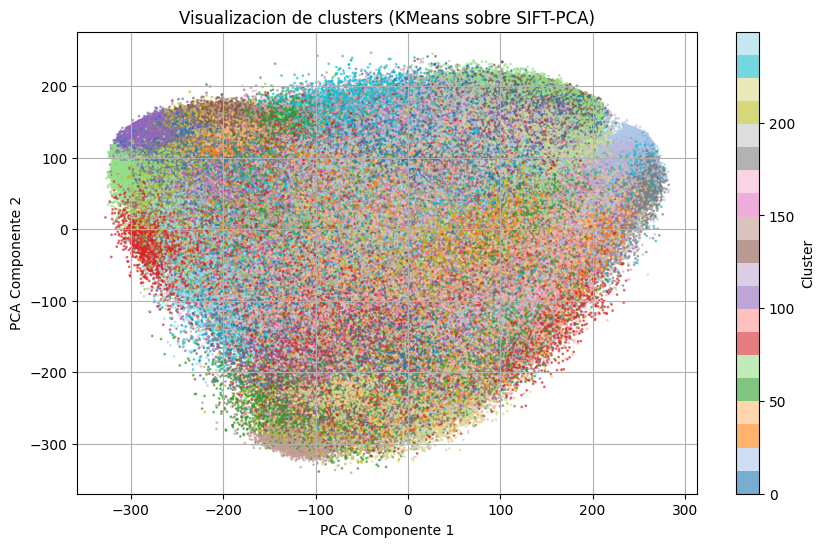

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combinar todos los descriptores reducidos en una sola matriz
X = np.vstack(descriptors)  # Esto es antes de aplicar KMeans
labels = kmeans.labels_     # Etiquetas de los clusters para cada descriptor

# Reducir a 2D para visualizar
pca_vis = PCA(n_components=2)
X_2d = pca_vis.fit_transform(X)

# Graficar
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=1, alpha=0.6)
plt.title("Visualizacion de clusters (KMeans sobre SIFT-PCA)")
plt.xlabel("PCA Componente 1")
plt.ylabel("PCA Componente 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()
